In [1]:
!pip install mediapipe
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 46.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.6 which is incompatible.
google-cloud-bigtable 2.27.0 requires google-api-core[grpc]<3.0.0dev,>=2.16.0, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
tensorflow-decision-forests 1.10.0 requires tens

In [2]:
import mediapipe as mp
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import os
import shutil
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import glob
import cv2
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
np.random.seed(42)

In [3]:
# Create a Holistic object to detect pose, face, and hands keypoints
mp_holistic = mp.solutions.holistic

# Drawing utilities
mp_drawing = mp.solutions.drawing_utils 

In [4]:
def mediapipe_detection(image, model):

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [5]:
def draw_styled_landmarks(image, results):

    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
def adjust_landmarks(arr,center):

    # Reshape the array to have shape (n, 3)
    arr_reshaped = arr.reshape(-1, 3)

    # Repeat the center array to have shape (n, 3)
    center_repeated = np.tile(center, (len(arr_reshaped), 1))

    # Subtract the center array from the arr array
    arr_adjusted = arr_reshaped - center_repeated

    # Reshape arr_adjusted back to shape (n*3,)
    arr_adjusted = arr_adjusted.reshape(-1)
    return(arr_adjusted)

In [7]:
def extract_keypoints(results):

    pose = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    nose=pose[:3]
    lh_wrist=lh[:3]
    rh_wrist=rh[:3]
    pose_adjusted = adjust_landmarks(pose,nose)
    lh_adjusted = adjust_landmarks(lh,lh_wrist)
    rh_adjusted = adjust_landmarks(rh,rh_wrist)
    return pose_adjusted, lh_adjusted, rh_adjusted

In [11]:
selected_words = [str(num).zfill(4) for num in range(11, 503)]  # If you have 502 signs


In [12]:
def make_keypoint_arrays(path,signer,split):
    """This function generates numpy arrays of keypoints for each video in the specified folder location.
    Args:
      signer(int): the signer of interest. Could be 01 or 02 or 03
      split(str): can be 'train', 'test' or 'val'
    """
    os.makedirs('karsl-502',exist_ok = True)
    os.makedirs(f'karsl-502/{signer}',exist_ok = True)
    os.makedirs(f'karsl-502/{signer}/{split}',exist_ok = True)
    working_path = f'karsl-502/{signer}/{split}'
    words_folder = os.path.join(path,str(signer),str(signer), split)
    
    # Loop through all the subfolders in the folder
    for word in tqdm(selected_words):

        video_files = os.listdir(os.path.join(words_folder, word))
          # Loop through the video files
        for video_file in video_files:
                # Open the video file
            video = sorted(os.listdir(os.path.join(words_folder, word, video_file)))

            # Initialize the list of keypoints for this video
            pose_keypoints, lh_keypoints, rh_keypoints = [], [], []
            with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
              # Loop through the video frames
              for frame in video:
                  # Perform any necessary preprocessing on the frame (e.g., resizing, normalization)
                frame = os.path.join(words_folder, word, video_file,frame)
                frame = cv2.imread(frame)
#                 frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                  # Normalize pixel values to the range [0, 1]
                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Extract keypoints
                pose, lh, rh = extract_keypoints(results)
                # Add the keypoints to the list for this video
                pose_keypoints.append(pose)
                lh_keypoints.append(lh)
                rh_keypoints.append(rh)           
                # Save the keypoints for this video to a numpy array
                pose_directory = os.path.join(working_path, word,'pose_keypoints')
                lh_directory = os.path.join(working_path, word,'lh_keypoints')
                rh_directory = os.path.join(working_path, word,'rh_keypoints')

                if not os.path.exists(pose_directory):
                    os.makedirs(pose_directory)

                if not os.path.exists(lh_directory):
                    os.makedirs(lh_directory)

                if not os.path.exists(rh_directory):
                    os.makedirs(rh_directory)

                pose_path = os.path.join(pose_directory, video_file)
                np.save(pose_path, pose_keypoints)

                lh_path = os.path.join(lh_directory, video_file)
                np.save(lh_path, lh_keypoints)

                rh_path = os.path.join(rh_directory, video_file)
                np.save(rh_path, rh_keypoints)

In [ ]:
 make_keypoint_arrays('/kaggle/input/karsl-502','01','train')
 #make_keypoint_arrays('/kaggle/input/karsl-502','01','test')
 #make_keypoint_arrays('/kaggle/input/karsl-502','02','train')
 #make_keypoint_arrays('/kaggle/input/karsl-502','02','test')
 #make_keypoint_arrays('/kaggle/input/karsl-502','03','train')
 #make_keypoint_arrays('/kaggle/input/karsl-502','03','test')

 24%|██▍       | 118/492 [2:56:43<13:37:39, 131.17s/it]

In [12]:
karsl_df = pd.read_excel('/kaggle/input/kars502labels/KARSL-502_Labels.xlsx')
mask = []
for i in karsl_df['SignID'].values:
    if str(i).zfill(4) in selected_words :
        mask.append(True)
    else :
        mask.append(False)
    
karsl_6 = karsl_df[mask].reset_index(drop=True)

karsl_6

,SignID,Sign-Arabic,Sign-English
0,289,أهلا وسهلاً,welcome
1,290,السلام عليكم,greeting
2,291,تفضل,here you are
3,292,جار,neighbor
4,293,شكراً,thanks
...,...,...,...
107,396,سورة الفاتحة,Al-Fatihah
108,397,آية,any
109,398,ليلة القدر,Night of Power
110,399,عيد,Feast


In [13]:
w2id = {w:i for w,i in zip(karsl_6['Sign-Arabic'].values,karsl_6['SignID'].values  )}
w2id

{'أهلا وسهلاً': 289,
 'السلام عليكم': 290,
 'تفضل': 291,
 'جار': 292,
 'شكراً': 293,
 'صديق': 294,
 'ضيف': 295,
 'عدو': 296,
 'عيب': 297,
 'هدية': 298,
 'بيت': 299,
 'جدار': 300,
 'سقف': 301,
 'باب': 302,
 'شباك': 303,
 'غرفة': 304,
 'غرفة نوم': 305,
 'سرير': 306,
 'مرتبة سرير ( حشية)': 307,
 'شرشف ( غطاء سرير)': 308,
 'وسادة ( مخدة)': 309,
 'شماعة ( مشجب)': 310,
 'خزانة ملابس': 311,
 'مطبخ': 312,
 'فرن غازي': 313,
 'بوتاغاز (طابخ)': 314,
 'طبق ( صحن)': 315,
 'سكين': 316,
 'شوكة': 317,
 'ملعقة': 318,
 'فنجان': 319,
 'مجمد (فريزر)': 320,
 'كأس ( كوب)': 321,
 'حافظ حرارة ( ترمس)': 322,
 'غرفة طعام': 323,
 'إبريق': 324,
 'طاولة': 325,
 'كنكة ( دلة)': 326,
 'دورة مياه (حمام)': 327,
 'كرسي': 328,
 'غسالة': 329,
 'منشفة': 330,
 'سجادة (زربية)': 331,
 'موكيت ( فرش أرضي) moquette': 332,
 'ثريا (نجفة)': 333,
 'مسجل': 334,
 'شريط كاست': 335,
 'تلفزيون (تلفاز)': 336,
 'طبق هوائي (دش)': 337,
 'شريط فيديو': 338,
 'كاميرا فيديو': 339,
 'كاميرا فوتوغرافية': 340,
 'هاتف ( تلفون)': 341,
 'غرفة ضيوف': 3

In [14]:
words= np.array([v for v in karsl_6['Sign-Arabic']])
print(words)

['أهلا وسهلاً' 'السلام عليكم' 'تفضل' 'جار' 'شكراً' 'صديق' 'ضيف' 'عدو'
 'عيب' 'هدية' 'بيت' 'جدار' 'سقف' 'باب' 'شباك' 'غرفة' 'غرفة نوم' 'سرير'
 'مرتبة سرير ( حشية)' 'شرشف ( غطاء سرير)' 'وسادة ( مخدة)' 'شماعة ( مشجب)'
 'خزانة ملابس' 'مطبخ' 'فرن غازي' 'بوتاغاز (طابخ)' 'طبق ( صحن)' 'سكين'
 'شوكة' 'ملعقة' 'فنجان' 'مجمد (فريزر)' 'كأس ( كوب)' 'حافظ حرارة ( ترمس)'
 'غرفة طعام' 'إبريق' 'طاولة' 'كنكة ( دلة)' 'دورة مياه (حمام)' 'كرسي'
 'غسالة' 'منشفة' 'سجادة (زربية)' 'موكيت ( فرش أرضي) moquette'
 'ثريا (نجفة)' 'مسجل' 'شريط كاست' 'تلفزيون (تلفاز)' 'طبق هوائي (دش)'
 'شريط فيديو' 'كاميرا فيديو' 'كاميرا فوتوغرافية' 'هاتف ( تلفون)'
 'غرفة ضيوف' 'فيديو' 'مبخرة' 'مدفأة' 'مفتاح' 'مروحة' 'تدفئة مركزية'
 'كهرباء' 'مكيف' 'سلك كهربائي' 'قابس كهربائي ( فيش)' 'حقيبة سفر' 'مكواة'
 'ميزان حرارة جوي' 'الله تعالى' 'محمد رسول الله' 'عيسى المسيح'
 'القرآن الكريم' 'الخلفاء الراشدون' 'السنة النبوية' 'أركان الإسلام'
 'أركان الإيمان' 'الشهادتين' 'يصلي / الصلاة' 'الزكاة' 'الصوم' 'العمرة'
 'الحج' 'ملائكة' 'رسول' 'يوم القيا

In [15]:
label_map = {label:num for num, label in enumerate(words)}
print(label_map)

{'أهلا وسهلاً': 0, 'السلام عليكم': 1, 'تفضل': 2, 'جار': 3, 'شكراً': 4, 'صديق': 5, 'ضيف': 6, 'عدو': 7, 'عيب': 8, 'هدية': 9, 'بيت': 10, 'جدار': 11, 'سقف': 12, 'باب': 13, 'شباك': 14, 'غرفة': 15, 'غرفة نوم': 16, 'سرير': 17, 'مرتبة سرير ( حشية)': 18, 'شرشف ( غطاء سرير)': 19, 'وسادة ( مخدة)': 20, 'شماعة ( مشجب)': 21, 'خزانة ملابس': 22, 'مطبخ': 23, 'فرن غازي': 24, 'بوتاغاز (طابخ)': 25, 'طبق ( صحن)': 26, 'سكين': 27, 'شوكة': 28, 'ملعقة': 29, 'فنجان': 30, 'مجمد (فريزر)': 31, 'كأس ( كوب)': 32, 'حافظ حرارة ( ترمس)': 33, 'غرفة طعام': 34, 'إبريق': 35, 'طاولة': 36, 'كنكة ( دلة)': 37, 'دورة مياه (حمام)': 38, 'كرسي': 39, 'غسالة': 40, 'منشفة': 41, 'سجادة (زربية)': 42, 'موكيت ( فرش أرضي) moquette': 43, 'ثريا (نجفة)': 44, 'مسجل': 45, 'شريط كاست': 46, 'تلفزيون (تلفاز)': 47, 'طبق هوائي (دش)': 48, 'شريط فيديو': 49, 'كاميرا فيديو': 50, 'كاميرا فوتوغرافية': 51, 'هاتف ( تلفون)': 52, 'غرفة ضيوف': 53, 'فيديو': 54, 'مبخرة': 55, 'مدفأة': 56, 'مفتاح': 57, 'مروحة': 58, 'تدفئة مركزية': 59, 'كهرباء': 60, 'مكيف': 61, 'س

In [16]:
def preprocess_data(data_path,signers,split,f_avg):
    """"
    This function loads the keypoints arrays for each video sequence of each word performed by the given signers, and extracts 
    a subsequence of length 'f_avg' from each sequence. Then it converts the sequences and labels to numpy arrays and returns 
    them as X and y.
    
    Args:
        signers(list): the signers of interest.
        split(str): can be 'train' or 'test'.
        f_avg(int): threshold for frame sampling.
    
    Returns:
        X(numpy.ndarray): array of sequences
        y(numpy.ndarray): array of one-hot encoded sign labels
    """

    # Initialize the lists of sequences and labels
    sequences, labels = [], []

    # Iterate through the list of words
    for word in tqdm(words):
        for signer in signers:
            # Iterate through the numpy arrays contained in the directory mentioned below
            for sequence in os.listdir(os.path.join(data_path,str(signer), split, str(w2id[word] ).zfill(4), 'lh_keypoints')):
                 # Load the left hand array
                res_lh = np.load(os.path.join(data_path,str(signer), split, str(w2id[word] ).zfill(4), 'lh_keypoints', sequence))

                # Determine how many rows to select
                num_frames = min(res_lh.shape[0], f_avg)
                res_lh = res_lh[:num_frames,:]
                while num_frames < f_avg:
                    res_lh = np.concatenate((res_lh, np.expand_dims(res_lh[-1,:], axis=0)), axis=0)
                    num_frames += 1

                # Load the right hand array
                res_rh = np.load(os.path.join(data_path,str(signer), split, str(w2id[word]).zfill(4), 'rh_keypoints', sequence))

                # Determine how many rows to select
                num_frames = min(res_rh.shape[0], f_avg)
                res_rh = res_rh[:num_frames,:]
                while num_frames < f_avg:
                    res_rh = np.concatenate((res_rh, np.expand_dims(res_rh[-1,:], axis=0)), axis=0)
                    num_frames += 1

                # Load the pose array
                res_pose = np.load(os.path.join(data_path,str(signer), split, str(w2id[word]).zfill(4), 'pose_keypoints', sequence))

                # Determine how many rows to select
                num_frames = min(res_pose.shape[0], f_avg)
                res_pose = res_pose[:num_frames,:]
                while num_frames < f_avg:
                    res_pose = np.concatenate((res_pose, np.expand_dims(res_pose[-1,:], axis=0)), axis=0)
                    num_frames += 1

                # Append the subsequence to the list of sequences
                sequences.append(np.concatenate((res_pose,res_lh, res_rh), axis=1))
                # Append the label to the list of labels
                labels.append(label_map[word])
    # Convert the lists of sequences and labels to numpy arrays
    X = np.array(sequences)
    y = to_categorical(labels).astype(int)

    return X, y

In [17]:
#train and validation splits
data_path = '/kaggle/input/blablabla/karsl-502'
# X_train,y_train=preprocess_data(data_path,['01','02','03'],'train',48)
X_train,y_train=preprocess_data(data_path,['01','02'],'train',48)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

100%|██████████| 112/112 [01:51<00:00,  1.01it/s]


(7503, 48, 225)
(7503, 112)
(1876, 48, 225)
(1876, 112)


In [18]:
#test split
X_test,y_test=preprocess_data(data_path,['01','02'],'test',48)
# X_test,y_test=preprocess_data(data_path,['01','02','03'],'test',48)
print(X_test.shape)
print(y_test.shape)

100%|██████████| 112/112 [00:22<00:00,  4.89it/s]

(1792, 48, 225)
(1792, 112)


In [19]:
# Define the Bidirectional LSTM model with Attention

    
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(words), activation='softmax')
])

# Compile the model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Set up early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor for early stopping
    mode='min',  # Set mode to 'min' for minimizing the metric
    patience=5,  # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore the best model weights
    verbose=1
)

In [20]:
model_training_history = model.fit(X_train, y_train, batch_size=32, validation_data=(X_val,y_val), validation_batch_size=32, epochs=50, callbacks=[early_stopping])


Epoch 1/50
235/235 [==============================] - 17s 24ms/step - loss: 3.5750 - categorical_accuracy: 0.1623 - val_loss: 2.1138 - val_categorical_accuracy: 0.4163
Epoch 2/50
235/235 [==============================] - 4s 19ms/step - loss: 1.5727 - categorical_accuracy: 0.5812 - val_loss: 1.0854 - val_categorical_accuracy: 0.7223
Epoch 3/50
235/235 [==============================] - 4s 17ms/step - loss: 0.7305 - categorical_accuracy: 0.8153 - val_loss: 0.5799 - val_categorical_accuracy: 0.8459
Epoch 4/50
235/235 [==============================] - 4s 18ms/step - loss: 0.4428 - categorical_accuracy: 0.8903 - val_loss: 0.2940 - val_categorical_accuracy: 0.9371
Epoch 5/50
235/235 [==============================] - 4s 17ms/step - loss: 0.2567 - categorical_accuracy: 0.9428 - val_loss: 0.3595 - val_categorical_accuracy: 0.9083
Epoch 6/50
235/235 [==============================] - 4s 17ms/step - loss: 0.2180 - categorical_accuracy: 0.9456 - val_loss: 0.1506 - val_categorical_accuracy: 0.96

In [21]:
# Evaluate the model on train data
model_evaluation_history = model.evaluate(X_train, y_train)

235/235 [==============================] - 2s 8ms/step - loss: 0.0193 - categorical_accuracy: 0.9973


In [22]:
# Evaluate the model on test data
model_evaluation_history = model.evaluate(X_test, y_test)

56/56 [==============================] - 0s 8ms/step - loss: 0.0596 - categorical_accuracy: 0.9860


In [23]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

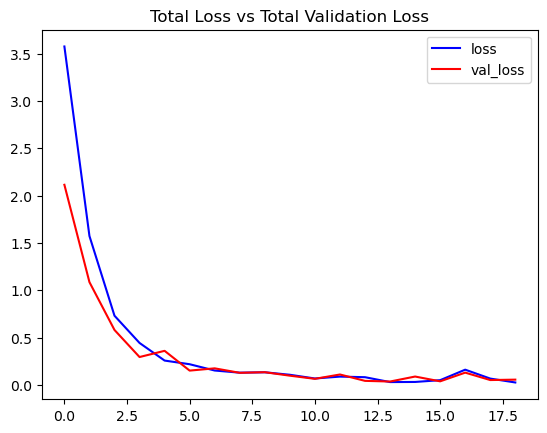

In [24]:
# Visualize the training and validation loss metrices.
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

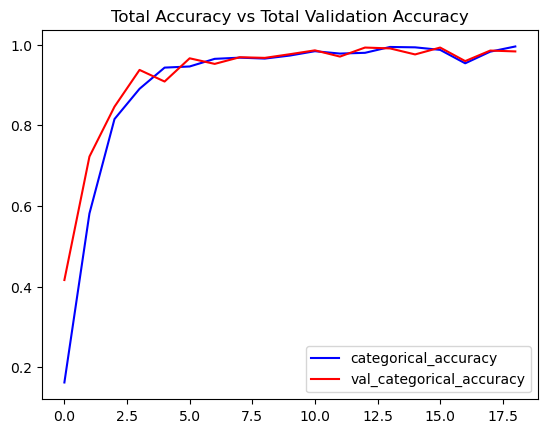

In [25]:
# Visualize the training and validation accuracy metrices.
plot_metric(model_training_history, 'categorical_accuracy', 'val_categorical_accuracy', 'Total Accuracy vs Total Validation Accuracy')


In [26]:
#Predicted sign
res = model.predict(X_test)
words[np.argmax(res[1])]

56/56 [==============================] - 2s 7ms/step


'أهلا وسهلاً'

In [27]:
#Real sign
words[np.argmax(y_test[1])]

'أهلا وسهلاً'

In [28]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'Kaleem_model_2_signers___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
model.save(model_file_name)

In [29]:
yhat = model.predict(X_test)

56/56 [==============================] - 0s 6ms/step


In [30]:
def get_key_by_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None

In [31]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [32]:
y = []
for v in ytrue:
    y.append(get_key_by_value(label_map, v))
print(y)

['أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'جار', 'جار', 'جار', 'جار', 'جار', 'جار', 'جار', 'جار', 'جار', 'جار', 'جار', 'جار', 'جار', 'جار', 'جار', 'جار', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'صديق', 'صديق', 'صديق', 'صديق', 'صديق', 'صديق', 'صديق', 'صديق', 'صديق', 'صديق', 'صديق', 'صديق', 'صديق', 'صديق', 'صديق',

In [33]:
y = [karsl_6[karsl_6['Sign-Arabic'] == v]['Sign-English'].values[0] for v in y]
print(y)

['welcome', 'welcome', 'welcome', 'welcome', 'welcome', 'welcome', 'welcome', 'welcome', 'welcome', 'welcome', 'welcome', 'welcome', 'welcome', 'welcome', 'welcome', 'welcome', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'friend', 'friend', 'fr

In [34]:
ypred = []
for v in yhat:
    ypred.append(get_key_by_value(label_map, v))
print(ypred)

['أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'يؤذن', 'أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'أهلا وسهلاً', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'السلام عليكم', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'تفضل', 'جار', 'جار', 'جار', 'جار', 'جار', 'جار', 'جار', 'جار', 'جار', 'جار', 'جار', 'جار', 'جار', 'جار', 'جار', 'جار', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'شكراً', 'صديق', 'صديق', 'صديق', 'صديق', 'صديق', 'صديق', 'صديق', 'صديق', 'صديق', 'صديق', 'صديق', 'صديق', 'صديق', 'صديق', 'صديق', 'صديق'

In [35]:
ypred = [karsl_6[karsl_6['Sign-Arabic'] == v]['Sign-English'].values[0] for v in ypred]
print(ypred)

['welcome', 'welcome', 'welcome', 'welcome', 'welcome', 'welcome', 'welcome', 'welcome', 'welcome', 'welcome', 'authorized', 'welcome', 'welcome', 'welcome', 'welcome', 'welcome', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'here you are', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'neighbor', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'friend', 'friend', 

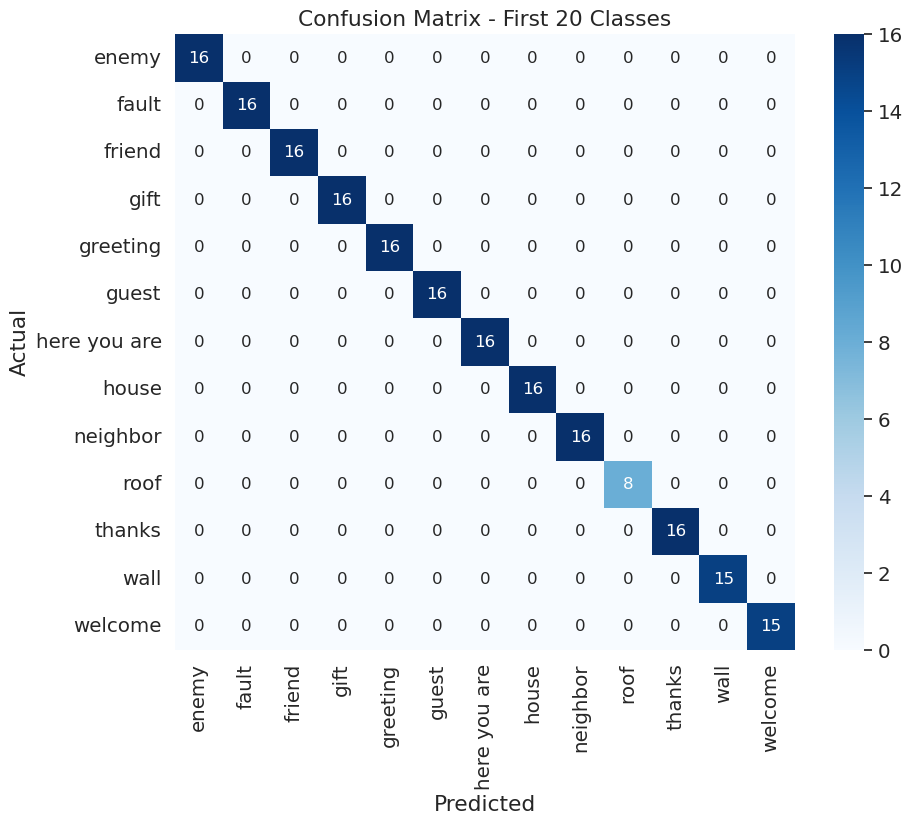

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y and ypred are your target labels and predicted labels, respectively

# Select the first 20 classes
y_subset = y[:200]
ypred_subset = ypred[:200]

# Get unique class labels
class_labels = np.unique(y_subset)

# Compute confusion matrix
cm = confusion_matrix(y_subset, ypred_subset, labels=class_labels)

# Create a DataFrame from the confusion matrix
df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.3)  # for label size
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="d", annot_kws={"size": 12})
plt.title("Confusion Matrix - First 20 Classes")
plt.show()
